In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
import itertools
import pandas as pd
from IPython.display import display
import os

figure_folder = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Analysis/figures/'

# Function

In [2]:
def DeltaR(eta1,phi1, eta2,phi2):
    dEta = eta1-eta2
    dPhi = abs(phi1-phi2)
    if dPhi > np.pi:
        dPhi = 2*np.pi - dPhi

    dR = (dPhi**2 + dEta**2)**0.5

    return dR

def FourMomentum(pt, eta, phi, m):
    px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
    e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
    return e, px, py, pz

def PtEtaPhiM(px, py, pz, e):
    E, px, py, pz = e, px, py, pz  
    P = np.sqrt(px**2 + py**2 + pz**2)
    pt = np.sqrt(px**2 + py**2)
    eta = 1./2.*np.log((P + pz)/(P - pz))
    phi = np.arctan(py/px)
    m = np.sqrt(np.sqrt((E**2 - px**2 - py**2 - pz**2)**2))

    return pt, eta, phi, m
    
def InvM(e, px, py, pz):
    return np.sqrt(e**2 - px**2 - py**2 - pz**2)

def Mjets(*arg):
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

In [3]:
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest              

In [4]:
def display_cutflow_table(result):
    nevent = result['nevent']
    cut_list = []
    for key in result:
        if key != 'Mass' and key != 'nevent' and key != 'Cross section':
            cut_list.append(key)

    pass_rate_list = []
    efficiency_list = []
    
    for i, cut in enumerate(cut_list):
        pass_rate_list.append(result[cut]/nevent)
        if i == 0:
            efficiency_list.append(pass_rate_list[i]/1)
        else:
            efficiency_list.append(pass_rate_list[i]/pass_rate_list[i-1])
    data = {'Cut': cut_list, 'pass rate': pass_rate_list, 'efficiency': efficiency_list}
    
    df = pd.DataFrame(data)
    
    display(df)

In [5]:
def print_sb_info(key, signal, background, L=[139]):
    nL = len(L)
    L = np.array(L)
    
    cross_section_s = signal[key] 
    cross_section_b = background[key] 
    nS = L * cross_section_s
    nB = L * cross_section_b
    
    content_format = '{:15} {:<12.3f} {:<12.3} {:<12.3}' + ' {:<12.3}'* nL
    print(content_format.format(key, cross_section_s, cross_section_b, nS[0]/nB[0], *nS/nB**0.5))

def signal_background_table(signal, background, L=[139]):
    # unit of luminosity L is fb
    nL = len(L)
    L = np.array(L)

    row_format = '{:15} {:<12} {:<12} {:<12}' + ' {:<12}'* nL
    print(row_format.format('', '', '', '', *L))
    print(row_format.format('', 'Signal', 'Background', 'S/B', *['S/sqrt{B}'] * nL))
    
    cross_section_s = signal['Cross section']
    cross_section_b = background['Cross section']
    nS = L * cross_section_s
    nB = L * cross_section_b
    
    content_format = '{:15} {:<12.3f} {:<12.3} {:<12.3}' + ' {:<12.3}'* nL
    print(content_format.format('No cut', cross_section_s, cross_section_b, nS[0]/nB[0], *nS/nB**0.5))
    
    for key in signal:
        if key != 'nevent' and key != 'Cross section':
            print_sb_info(key, signal, background, L)
            
def combine_result_dict(dict_pre, dict_):
    result = {
        **dict_pre,
        **dict_,
    }
    result.pop('Pre cut', None)   
    return result

def combine_cross_section(dict1, dict2):
    result = {}
    for key in dict1:
        if key != 'nevent':
            result[key] = dict1[key] + dict2[key]
    return result  

# ATLAS diHiggs selection 

In [6]:
def deltaR_condition(R1, R2, m4j):
    # R1: Delta R of leading Higgs candidate
    # R2: Delta R of sub-leading Higgs candidate
    
    if m4j < 1250:
        if R1 > 653 / m4j + 0.475:
            return False
        if R1 < 360 / m4j - 0.5:
            return False

        if R2 > 875 / m4j + 0.35:
            return False
        if R2 < 235 / m4j:
            return False      
    else:
        if R1 > 1:
            return False
        if R1 < 0:
            return False

        if R2 > 1:
            return False
        if R2 < 0:
            return False
    return True

def DHH(m1, m2):
    # m1: mass of leading Higgs candidate
    # m2: mass of sub-leading Higgs candidate
    
    return abs(m1 - 120/110*m2) / (1 + (120/110)**2)**0.5
    
def pt_condition(pt1, pt2, m4j):
    # pt1: PT of leading Higgs candidate
    # pt2: PT of sub-leading Higgs candidate
    
    if pt1 < 0.5 * m4j - 103:
        return False
    if pt2 < 0.33 * m4j - 73:
        return False
    return True

def XHH(m1, m2):
    # m1: leading Higgs candidate mass
    # m2: sub-leading Higgs candidate mass
    
    return (((m1-120)/(0.1*m1))**2 + ((m2-110)/(0.1*m2))**2)**0.5

def XWt(mW, mt):
    # mW: W boson candidate mass
    # mt: top candidate mass
    
    return (((mW-80)/(0.1*mW))**2 + ((mt-173)/(0.1*mt))**2)**0.5

In [7]:
def print_count_xsection(text, cross_section, count, total):
    print(text, count, cross_section * count / total)

## Root file

In [8]:
def diHiggs_selection_ATLAS(file_path, mass, xection=None, title='', nevent_max=1000):
    # input: root file
    # Eta PT BTag cut: |eta| < 2.5, PT > 40 GeV for 4 b-jets
    
    root_file = uproot.open(file_path)['Delphes;1']

    Eta_PT_BTag_count = 0
    dR_count = 0
    HPT_count = 0
    HEta_count = 0
    XHH_count = 0
    XWt_count = 0

    jet_PT = root_file['Jet.PT'].array(entry_stop=nevent_max)
    jet_Eta = root_file['Jet.Eta'].array(entry_stop=nevent_max)
    jet_Phi = root_file['Jet.Phi'].array(entry_stop=nevent_max)
    jet_Mass = root_file['Jet.Mass'].array(entry_stop=nevent_max)
    jet_BTag = root_file['Jet.BTag'].array(entry_stop=nevent_max)
    
    if xection:
        cross_section = xection
    else:
        # unit: pb -> fb
        cross_section = root_file['Event.Weight'].array(entry_stop=1)[0][0] * 1000
    
    nevent = len(jet_PT)
    
    for event in tqdm(range(nevent)):
        
        # |eta| < 2.5 & PT > 40 GeV
        eta_pt_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40))[0]
        
        # |eta| < 2.5 & PT > 40 GeV & b-tagged
        eta_pt_bTag_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40) & (jet_BTag[event] == 1))[0]

        # >= 4 b-jet
        if len(eta_pt_bTag_cut) < 4: 
            continue
        Eta_PT_BTag_count += 1
        
        # choose 4 highest pt b-jets
        h_jets = eta_pt_bTag_cut[0:4]

        PT = jet_PT[event][h_jets]
        Eta = jet_Eta[event][h_jets]
        Phi = jet_Phi[event][h_jets]
        Mass = jet_Mass[event][h_jets]

        e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
        m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

        # The pairing satisfy the delta R condition
        dR_pairing = []
        for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
            PT1 = PT[[i1,i2]]
            PT2 = PT[[i3,i4]]
            # sorted by PT scalar sum
            if np.sum(PT1) < np.sum(PT2):
                i1, i2, i3, i4 = i3, i4, i1, i2
                
            PT1 = PT[[i1,i2]] 
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]
            
            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))
            
            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]
            
            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))
                
            dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
            dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])
            
            if deltaR_condition(dR1, dR2, m4j):
                d = DHH(mH1, mH2)
                dR_pairing.append([i1,i2,i3,i4, d])
                
        if len(dR_pairing) == 0:
            continue
        dR_count += 1
        
        # choose the pairing with minimum DHH
        h_candidate = dR_pairing[0][0:4]
        min_DHH = dR_pairing[0][4]
        for i1,i2,i3,i4, d in dR_pairing:
            if d < min_DHH:
                min_DHH = d
                h_candidate = [i1,i2,i3,i4]
                
        i1, i2 = h_candidate[0:2] 
        i3, i4 = h_candidate[2:4] 
        
        PT1 = PT[[i1,i2]]
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]

        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))
            
        if not pt_condition(PTH1, PTH2, m4j):
            continue
        HPT_count += 1    
        
        if abs(EtaH1 - EtaH2) > 1.5:
            continue
        HEta_count += 1
        
        # signal region
        if XHH(MassH1, MassH2) > 1.6:
            continue
        XHH_count += 1
        
        # Top veto
        not_h_jets = []
        for jet in eta_pt_cut:
            if jet not in h_jets:
                not_h_jets.append(jet)
        
        XWt_flag = False
        if len(not_h_jets) >= 2:
            for i1,i2 in itertools.combinations(not_h_jets, 2):
                PTW = jet_PT[event][[i1,i2]]
                EtaW = jet_Eta[event][[i1,i2]]
                PhiW = jet_Phi[event][[i1,i2]]
                MassW = jet_Mass[event][[i1,i2]]

                eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
                mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

                for b in h_jets:
                    PTb = jet_PT[event][b]
                    Etab = jet_Eta[event][b]
                    Phib = jet_Phi[event][b]
                    Massb = jet_Mass[event][b]
                    eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

                    et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
                    mt = InvM(et, pxt, pyt, pzt)

                    if XWt(mW, mt) < 1.5:
                        XWt_flag = True
                        break
                        
                if XWt_flag:
                    break
        if XWt_flag:
            continue
        XWt_count += 1

    print(title)
    print(f'In {nevent} events')
    print(f'Cross section: {cross_section} fb')
    
    print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, Eta_PT_BTag_count, nevent)
    print_count_xsection('Delta R:', cross_section, dR_count, nevent)
    print_count_xsection('Higgs PT:', cross_section, HPT_count, nevent)
    print_count_xsection('Higgs Eta:', cross_section, HEta_count, nevent)
    print_count_xsection('Higgs signal region:', cross_section, XHH_count, nevent)
    print_count_xsection('Top veto:', cross_section, XWt_count, nevent)

    
    cutflow_count = {
        'Mass': mass,
        'nevent': nevent,
        'Cross section': cross_section,
        'Eta PT BTag cut': Eta_PT_BTag_count,
        'Delta R': dR_count,
        'Higgs PT cut': HPT_count,
        'Higgs Eta cut': HEta_count,
        'Higgs signal': XHH_count,
        'Top veto': XWt_count, 
    }
    
    cutflow_cross_section = {  
        'nevent': nevent,
        'Cross section': cross_section,
        'Eta PT BTag cut': cross_section * Eta_PT_BTag_count / nevent,
        'Delta R': cross_section * dR_count / nevent,
        'Higgs PT cut': cross_section * HPT_count / nevent,
        'Higgs Eta cut': cross_section * HEta_count / nevent,
        'Higgs signal': cross_section * XHH_count / nevent,
        'Top veto': cross_section * XWt_count / nevent, 
    }
    return cutflow_count, cutflow_cross_section

In [7]:
def get_number_of_bjet(file_path, mass, xection=None, title='', nevent_max=1000):
    # Eta PT BTag cut: |eta| < 2.5, PT > 40 GeV for 4 b-jets
    
    root_file = uproot.open(file_path)['Delphes;1']

    Eta_PT_BTag_count = 0

    jet_PT = root_file['Jet.PT'].array(entry_stop=nevent_max)
    jet_Eta = root_file['Jet.Eta'].array(entry_stop=nevent_max)
    jet_BTag = root_file['Jet.BTag'].array(entry_stop=nevent_max)
    
    if xection:
        cross_section = xection
    else:
        # unit: pb -> fb
        cross_section = root_file['Event.Weight'].array(entry_stop=1)[0][0] * 1000
    
    nevent = min(len(jet_PT), nevent_max)
    
    # 0: before Four tag cut, 1: after Four tag cut
    nbj = [[], []]
    
    for event in tqdm(range(nevent)):
        
        BTag = jet_BTag[event]

        nbj[0].append(np.sum(BTag))
        
        # |eta| < 2.5 & PT > 40 GeV
        eta_pt_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40))[0]
        
        # |eta| < 2.5 & PT > 40 GeV & b-tagged
        eta_pt_bTag_cut = np.where((np.abs(jet_Eta[event]) < 2.5) & (jet_PT[event] > 40) & (jet_BTag[event] == 1))[0]

        # >= 4 b-jet
        if len(eta_pt_bTag_cut) < 4: 
            continue
        Eta_PT_BTag_count += 1
        
        nbj[1].append(len(eta_pt_bTag_cut))
        

    print(title)
    print(f'In {nevent} events')
    print(f'Cross section: {cross_section} fb')
    print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)
    return nbj

## HDF5

In [20]:
def from_rootfile_to_HDF5(root_file, output_file):
    # 生成給 SPANet 預測的 HDF5 檔案
    min_bjets = 4
    cmd = f'python to_SPANet_data_diHiggs_PT40.py {root_file} {output_file} {min_bjets}'
    os.system(cmd)
    
    # # 用 SPANet 預測的 HDF5 檔案
    # cmd = 'conda activae SPANet'
    # os.system(cmd)

    # cmd = 'cd /home/r10222035/SPANet/'
    # os.system(cmd)

    # model = 'diHiggs/1M_diHiggs_4b_MV2c10_PT40/version_0'
    # output_name = '100k_diHiggs_4b_MV2c10_PT40_background_predict.h5'
    # test_file = ''
    # cmd = f'python predict.py {model} {output_name} -tf {test_file} --gpu'
    # os.system(cmd)

In [8]:
def SPANet_pairing(jet_PT, h_jets):
    if np.sum(jet_PT[h_jets[0:2]]) > np.sum(jet_PT[h_jets[2:4]]):
        return [0, 1, 2, 3]
    else:
        return [2, 3, 0, 1]

def deltaR_minDHH_pairing(PT, Eta, Phi, Mass):
    e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
    m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
    
    # The pairing satisfy the delta R condition
    dR_pairing = []
    for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
        PT1 = PT[[i1,i2]]
        PT2 = PT[[i3,i4]]
        # sorted by PT scalar sum
        if np.sum(PT1) < np.sum(PT2):
            i1, i2, i3, i4 = i3, i4, i1, i2

        PT1 = PT[[i1,i2]] 
        Eta1 = Eta[[i1,i2]]
        Phi1 = Phi[[i1,i2]]
        Mass1 = Mass[[i1,i2]]
        
        e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
        mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

        PT2 = PT[[i3,i4]]
        Eta2 = Eta[[i3,i4]]
        Phi2 = Phi[[i3,i4]]
        Mass2 = Mass[[i3,i4]]

        e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
        mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

        dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
        dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

        if deltaR_condition(dR1, dR2, m4j):
            d = DHH(mH1, mH2)
            dR_pairing.append([i1,i2,i3,i4, d])

    if len(dR_pairing) == 0:
        return []

    # choose the pairing with minimum DHH
    h_candidate = dR_pairing[0][0:4]
    min_DHH = dR_pairing[0][4]
    for i1,i2,i3,i4, d in dR_pairing:
        if d < min_DHH:
            min_DHH = d
            h_candidate = [i1,i2,i3,i4]
    return h_candidate

In [9]:
def diHiggs_selection_ATLAS_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'SPANet':
                # SPANet pairing
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                h_candidate = SPANet_pairing(jet_PT, h_jets)
            elif pairing_method == 'deltaR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                
                h_candidate = deltaR_minDHH_pairing(PT, Eta, Phi, Mass)
            else:
                return 'Pairing method does not exist.'
            
            if len(h_candidate) == 0:
                continue
            dR_count += 1
                                                
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2 = h_candidate[0:2] 
            i3, i4 = h_candidate[2:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1    

            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1

            # signal region
            if XHH(MassH1, MassH2) > 1.6:
                continue
            XHH_count += 1

            # # Top veto
            # not_h_jets = []
            # for jet in eta_pt_cut:
            #     if jet not in h_jets:
            #         not_h_jets.append(jet)
                
            # XWt_flag = False
            # if len(not_h_jets) >= 2:
            #     for i1,i2 in itertools.combinations(not_h_jets, 2):
            #         PTW = jet_PT[[i1,i2]]
            #         EtaW = jet_Eta[[i1,i2]]
            #         PhiW = jet_Phi[[i1,i2]]
            #         MassW = jet_Mass[[i1,i2]]

            #         eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
            #         mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

            #         for b in h_jets:
            #             PTb = jet_PT[b]
            #             Etab = jet_Eta[b]
            #             Phib = jet_Phi[b]
            #             Massb = jet_Mass[b]
            #             eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

            #             et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
            #             mt = InvM(et, pxt, pyt, pzt)

            #             if XWt(mW, mt) < 1.5:
            #                 XWt_flag = True
            #                 break

            #         if XWt_flag:
            #             break

            XWt_flag = False           
            for b in h_jets:
                PTb = jet_PT[b]
                Etab = jet_Eta[b]
                Phib = jet_Phi[b]
                Massb = jet_Mass[b]
                eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

                for i1,i2 in itertools.combinations(eta_pt_cut, 2):
                    if b == i1 or b == i2:
                        continue
                    PTW = jet_PT[[i1,i2]]
                    EtaW = jet_Eta[[i1,i2]]
                    PhiW = jet_Phi[[i1,i2]]
                    MassW = jet_Mass[[i1,i2]]

                    eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
                    mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

                    et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
                    mt = InvM(et, pxt, pyt, pzt)

                    if XWt(mW, mt) < 1.5:
                        XWt_flag = True
                        break

                if XWt_flag:
                    break

            if XWt_flag:
                continue
            XWt_count += 1

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        if pairing_method == 'deltaR_minDHH':
            print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
        print_count_xsection('Higgs signal region:', cross_section_abs, XHH_count, nevent)
        print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
        
        cutflow_count = {
#             'Mass': mass,
            'nevent': tot_event,
            'Cross section': cross_section,
            'Eta PT BTag cut': Eta_PT_BTag_count,
            'Delta R': dR_count,
            'Higgs PT cut': HPT_count,
            'Higgs Eta cut': HEta_count,
            'Higgs signal': XHH_count,
            'Top veto': XWt_count, 
        }
         
        cutflow_cross_section = {
            'nevent': nevent,
            'Cross section': cross_section,
            'Eta PT BTag cut': cross_section_abs,
            'Delta R': cross_section_abs * dR_count / nevent,
            'Higgs PT cut': cross_section_abs * HPT_count / nevent,
            'Higgs Eta cut': cross_section_abs * HEta_count / nevent,
            'Higgs signal': cross_section_abs * XHH_count / nevent,
            'Top veto': cross_section_abs * XWt_count / nevent, 
        }
        
        if pairing_method != 'deltaR_minDHH':
            cutflow_count.pop('Delta R')
            cutflow_cross_section.pop('Delta R')
        return cutflow_count, cutflow_cross_section

In [10]:
def diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass, xection=None, title='', nevent_max=1000):
    # input file has jet matching data
    # count how many events in which the four b-jets all from Higgs
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        dR_count1 = 0
        dR_count2 = 0
        dR_count3 = 0
        dR_count4 = 0

        cross_section = xection

        # 0: all from Higgs, 1: not all from Higgs
        dR_list = [[[],[]], [[],[]]]
        m4j_list = [[], []]

        # before delta R cut
        unknown_pair_count = 0
        correct_pair_count = 0
        incorrect_pair_count1 = 0
        incorrect_pair_count2 = 0
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        for event in tqdm(range(nevent)):

            nj = f['source/mask'][event].sum()
            jet_PT = f['source/pt'][event][:nj]
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = f['source/mass'][event][:nj]
            jet_BTag = f['source/btag'][event][:nj]
            
            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            # choose 4 highest pt b-jets
            h_jets = eta_pt_bTag_cut[0:4]

            unknown = False
            correct = True
            all_jet_in_eta_pt_bTag_cut = True
            if not(f['h1/mask'][event] and f['h2/mask'][event]):
                unknown = True
            else:
                # correct jet matching
                h_id = [f['h1/b1'][event], f['h1/b2'][event], 
                        f['h2/b1'][event], f['h2/b2'][event],]

                # compare to the correct jet matching
                for j in h_id:
                    if j not in h_jets:
                        correct = False
                        break
                for j in h_id:
                    if j not in eta_pt_bTag_cut:
                        all_jet_in_eta_pt_bTag_cut = False
                        break
                        
            if unknown:
                unknown_pair_count += 1
            elif correct:
                correct_pair_count += 1
            elif all_jet_in_eta_pt_bTag_cut:
                incorrect_pair_count1 += 1
            else:
                incorrect_pair_count2 += 1
                    
            # Total invariant mass of 4 b-jets
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            # The pairing satisfy the delta R condition
            dR_pairing = []
            for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
                PT1 = PT[[i1,i2]]
                Eta1 = Eta[[i1,i2]]
                Phi1 = Phi[[i1,i2]]
                Mass1 = Mass[[i1,i2]]
                e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
                mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

                PT2 = PT[[i3,i4]]
                Eta2 = Eta[[i3,i4]]
                Phi2 = Phi[[i3,i4]]
                Mass2 = Mass[[i3,i4]]
                e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
                mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

                if np.sum(PT1) < np.sum(PT2):
                    PT1, PT2 = PT2, PT1
                    Eta1, Eta2 = Eta2, Eta1
                    Phi1, Phi2 = Phi2, Phi1
                    Mass1, Mass2 = Mass2, Mass1
                    i1, i2, i3, i4 = i3, i4, i1, i2

                dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
                dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

                if deltaR_condition(dR1, dR2, m4j):
                    d = DHH(mH1, mH2)
                    dR_pairing.append([i1,i2,i3,i4, d, dR1, dR2])
            
            if len(dR_pairing) > 0 :
                if unknown:
                    dR_count4 += 1
                elif correct:
                    dR_count1 += 1
                elif all_jet_in_eta_pt_bTag_cut:
                    dR_count2 += 1
                else:
                    dR_count3 += 1

            if len(dR_pairing) == 0:
                continue
            dR_count += 1

            min_DHH = -1
            h_candidate = []
            deltaR = []
            for i1,i2,i3,i4, d, dR1, dR2 in dR_pairing:
                if min_DHH < 0 or d < min_DHH:
                    min_DHH = d
                    h_candidate = [i1,i2,i3,i4]
                    deltaR = [dR1, dR2]

            if correct: 
                dR_list[0][0].append(deltaR[0])
                dR_list[0][1].append(deltaR[1])
                m4j_list[0].append(m4j)
            else:
                dR_list[1][0].append(deltaR[0])
                dR_list[1][1].append(deltaR[1])
                m4j_list[1].append(m4j)

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', Eta_PT_BTag_count, cross_section * Eta_PT_BTag_count / nevent)
        print(f'Total: {correct_pair_count + incorrect_pair_count1 + incorrect_pair_count2 + unknown_pair_count}, All from Higgs: {correct_pair_count}, not all from Higgs: {incorrect_pair_count1 + incorrect_pair_count2}, unknown: {unknown_pair_count}')
        print('Delta R:', dR_count, dR_count * cross_section / nevent)
        print(f'Total: {dR_count1 + dR_count2 + dR_count3 + dR_count4}, All from Higgs: {dR_count1}, not all from Higgs: {dR_count2 + dR_count3}, unknown: {dR_count4}')

        result = {
            'Mass': mass,
            'nevent': nevent,
            'Cross section': cross_section,
            'Eta PT BTag cut': Eta_PT_BTag_count,
            'Delta R': dR_count,
        }
        return result, dR_list, m4j_list

In [11]:
def get_diHiggs_deltaR_m4j_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        # 0: leading Higgs, 1: sub-leading Higgs before Higgs region cut
        deltaR = [[],[]]
        m_tot = []
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # # |eta| < 2.5 & PT > 40 GeV
            # eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            # choose 4 highest pt b-jets
            h_jets = eta_pt_bTag_cut[0:4]
            
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]

            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))
            
            # all pairing 
            dR_pairing = []
            for (i1,i2), (i3,i4) in all_pairs([0,1,2,3]):
                PT1 = PT[[i1,i2]]
                PT2 = PT[[i3,i4]]
                # sorted by PT scalar sum
                if np.sum(PT1) < np.sum(PT2):
                    i1, i2, i3, i4 = i3, i4, i1, i2

                PT1 = PT[[i1,i2]] 
                Eta1 = Eta[[i1,i2]]
                Phi1 = Phi[[i1,i2]]
                Mass1 = Mass[[i1,i2]]
                
                e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
                mH1 = InvM(np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1))

                PT2 = PT[[i3,i4]]
                Eta2 = Eta[[i3,i4]]
                Phi2 = Phi[[i3,i4]]
                Mass2 = Mass[[i3,i4]]

                e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
                mH2 = InvM(np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2))

                dR1 = DeltaR(Eta1[0], Phi1[0], Eta1[1], Phi1[1])
                dR2 = DeltaR(Eta2[0], Phi2[0], Eta2[1], Phi2[1])

                # if deltaR_condition(dR1, dR2, m4j):
                d = DHH(mH1, mH2)
                dR_pairing.append([i1,i2,i3,i4, d, dR1,dR2])

            # choose the pairing with minimum DHH
            h_candidate = dR_pairing[0][0:4]
            min_DHH = dR_pairing[0][4]
            dR = dR_pairing[0][5:7]
            for i1,i2,i3,i4, d, dR1,dR2 in dR_pairing:
                if d < min_DHH:
                    min_DHH = d
                    h_candidate = [i1,i2,i3,i4]
                    dR = [dR1, dR2]

            deltaR[0].append(dR[0])
            deltaR[1].append(dR[1])

            m_tot.append(m4j)

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        # cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        # print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        # print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        # print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
        # print_count_xsection('Higgs signal region:', cross_section_abs, XHH_count, nevent)
        # print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
        
        return deltaR, m_tot

In [12]:
def get_diHiggs_PT_m4j_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        # 0: leading Higgs, 1: sub-leading Higgs
        ptH = [[], []]
        m_tot = []
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'SPANet':
                # SPANet pairing
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                h_candidate = SPANet_pairing(jet_PT, h_jets)
            elif pairing_method == 'deltaR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                
                h_candidate = deltaR_minDHH_pairing(PT, Eta, Phi, Mass)
            else:
                return 'Pairing method does not exist.'
            
            if len(h_candidate) == 0:
                continue
            dR_count += 1
                                                
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2 = h_candidate[0:2] 
            i3, i4 = h_candidate[2:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            ptH[0].append(PTH1)
            ptH[1].append(PTH2)
            m_tot.append(m4j)
            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1    

            

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        
        return ptH, m_tot

In [13]:
def get_diHiggs_dEta_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        # 0: leading Higgs, 1: sub-leading Higgs before Higgs region cut
        dEta = []
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'SPANet':
                # SPANet pairing
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                h_candidate = SPANet_pairing(jet_PT, h_jets)
            elif pairing_method == 'deltaR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                
                h_candidate = deltaR_minDHH_pairing(PT, Eta, Phi, Mass)
            else:
                return 'Pairing method does not exist.'
            
            if len(h_candidate) == 0:
                continue
            dR_count += 1
                                                
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2 = h_candidate[0:2] 
            i3, i4 = h_candidate[2:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1    

            dEta.append(abs(EtaH1 - EtaH2))
            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1   

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)

        return dEta

In [14]:
def get_diHiggs_mass_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        # XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        # 0: leading Higgs, 1: sub-leading Higgs before Higgs region cut
        mh = [[],[]]
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'SPANet':
                # SPANet pairing
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                h_candidate = SPANet_pairing(jet_PT, h_jets)
            elif pairing_method == 'deltaR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                
                h_candidate = deltaR_minDHH_pairing(PT, Eta, Phi, Mass)
            else:
                return 'Pairing method does not exist.'
            
            if len(h_candidate) == 0:
                continue
            dR_count += 1
                                                
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2 = h_candidate[0:2] 
            i3, i4 = h_candidate[2:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1    

            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1

            mh[0].append(MassH1)
            mh[1].append(MassH2)            
            # signal region
            if XHH(MassH1, MassH2) > 1.6:
                continue
            XHH_count += 1

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
        print_count_xsection('Higgs signal region:', cross_section_abs, XHH_count, nevent)

        return mh

In [15]:
def get_mHH_HDF5(file_path, tot_event, pairing_method,  xection=None, title='', nevent_max=1000):
    # 已經過 |eta| < 2.5, PT > 40 GeV for 4 jets, >= 4 b-jets 篩選，並且通過 SPANet
    
    with h5py.File(file_path, 'r') as f:
        Eta_PT_BTag_count = 0
        dR_count = 0
        HPT_count = 0
        HEta_count = 0
        XHH_count = 0
        XWt_count = 0

        cross_section = xection
        
        nevent = min(f['source/pt'].shape[0], nevent_max)
        # 0: , 1: corrected
        mHH = [[],[]]
        for event in tqdm(range(nevent)):
            
            nj = f['source/mask'][event].sum()
            # 須將資料標準化還原
            jet_PT = np.exp(f['source/pt'][event][:nj])
            jet_Eta = f['source/eta'][event][:nj]
            jet_Phi = f['source/phi'][event][:nj]
            jet_Mass = np.exp(f['source/mass'][event][:nj])
            jet_BTag = f['source/btag'][event][:nj]

            # |eta| < 2.5 & PT > 40 GeV
            eta_pt_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40))[0]

            # |eta| < 2.5 & PT > 40 GeV & b-tagged
            eta_pt_bTag_cut = np.where((np.abs(jet_Eta) < 2.5) & (jet_PT > 40) & (jet_BTag == 1))[0]

            # >= 4 b-jet
            if len(eta_pt_bTag_cut) < 4: 
                continue
            Eta_PT_BTag_count += 1
            
            if pairing_method == 'SPANet':
                # SPANet pairing
                h_jets = [f['h1/b1'][event], f['h1/b2'][event], 
                          f['h2/b1'][event], f['h2/b2'][event],]
                h_candidate = SPANet_pairing(jet_PT, h_jets)
            elif pairing_method == 'deltaR_minDHH':
                # choose 4 highest pt b-jets
                h_jets = eta_pt_bTag_cut[0:4]
                
                PT = jet_PT[h_jets]
                Eta = jet_Eta[h_jets]
                Phi = jet_Phi[h_jets]
                Mass = jet_Mass[h_jets]
                
                h_candidate = deltaR_minDHH_pairing(PT, Eta, Phi, Mass)
            else:
                return 'Pairing method does not exist.'
            
            if len(h_candidate) == 0:
                continue
            dR_count += 1
                                                
            PT = jet_PT[h_jets]
            Eta = jet_Eta[h_jets]
            Phi = jet_Phi[h_jets]
            Mass = jet_Mass[h_jets]
            
            e, px, py, pz = FourMomentum(PT, Eta, Phi, Mass)
            m4j = InvM(np.sum(e), np.sum(px), np.sum(py), np.sum(pz))

            i1, i2 = h_candidate[0:2] 
            i3, i4 = h_candidate[2:4] 

            PT1 = PT[[i1,i2]]
            Eta1 = Eta[[i1,i2]]
            Phi1 = Phi[[i1,i2]]
            Mass1 = Mass[[i1,i2]]

            e1, px1, py1, pz1 = FourMomentum(PT1, Eta1, Phi1, Mass1)
            PTH1, EtaH1, PhiH1, MassH1 = PtEtaPhiM(np.sum(px1), np.sum(py1), np.sum(pz1), np.sum(e1))

            PT2 = PT[[i3,i4]]
            Eta2 = Eta[[i3,i4]]
            Phi2 = Phi[[i3,i4]]
            Mass2 = Mass[[i3,i4]]

            e2, px2, py2, pz2 = FourMomentum(PT2, Eta2, Phi2, Mass2)
            PTH2, EtaH2, PhiH2, MassH2 = PtEtaPhiM(np.sum(px2), np.sum(py2), np.sum(pz2), np.sum(e2))

            if not pt_condition(PTH1, PTH2, m4j):
                continue
            HPT_count += 1    

            if abs(EtaH1 - EtaH2) > 1.5:
                continue
            HEta_count += 1

            # signal region
            if XHH(MassH1, MassH2) > 1.6:
                continue
            XHH_count += 1

            XWt_flag = False           
            for b in h_jets:
                PTb = jet_PT[b]
                Etab = jet_Eta[b]
                Phib = jet_Phi[b]
                Massb = jet_Mass[b]
                eb, pxb, pyb, pzb = FourMomentum(PTb, Etab, Phib, Massb)

                for i1,i2 in itertools.combinations(eta_pt_cut, 2):
                    if b == i1 or b == i2:
                        continue
                    PTW = jet_PT[[i1,i2]]
                    EtaW = jet_Eta[[i1,i2]]
                    PhiW = jet_Phi[[i1,i2]]
                    MassW = jet_Mass[[i1,i2]]

                    eW, pxW, pyW, pzW = FourMomentum(PTW, EtaW, PhiW, MassW)
                    mW = InvM(np.sum(eW), np.sum(pxW), np.sum(pyW), np.sum(pzW))

                    et, pxt, pyt, pzt = np.sum(eW) + eb, np.sum(pxW) + pxb, np.sum(pyW) + pyb, np.sum(pzW) + pzb
                    mt = InvM(et, pxt, pyt, pzt)

                    if XWt(mW, mt) < 1.5:
                        XWt_flag = True
                        break

                if XWt_flag:
                    break

            if XWt_flag:
                continue
            XWt_count += 1

            e1, px1, py1, pz1 = np.sum(e1), np.sum(px1), np.sum(py1), np.sum(pz1)
            e2, px2, py2, pz2 = np.sum(e2), np.sum(px2), np.sum(py2), np.sum(pz2)
            mHH[0].append(InvM(e1 + e2, px1 + px2, py1 + py2, pz1 + pz2))

            mHiggs = 125
            e1, px1, py1, pz1 = np.array([e1, px1, py1, pz1]) * mHiggs/MassH1
            e2, px2, py2, pz2 = np.array([e2, px2, py2, pz2]) * mHiggs/MassH2
            mHH[1].append(InvM(e1 + e2, px1 + px2, py1 + py2, pz1 + pz2))

        print(title)
        print(f'In {nevent} events')
        print(f'Cross section: {cross_section} fb')

        print_count_xsection('|eta| < 2.5, PT > 40 GeV for 4 b-jets:', cross_section, f['source/pt'].shape[0], tot_event)
        # 經過 |eta| < 2.5, PT > 40 GeV for 4 b-jets 的截面
        cross_section_abs = cross_section * f['source/pt'].shape[0] / tot_event
        
        if pairing_method == 'deltaR_minDHH':
            print_count_xsection('Delta R:', cross_section_abs, dR_count, nevent)
        print_count_xsection('Higgs PT:', cross_section_abs, HPT_count, nevent)
        print_count_xsection('Higgs Eta:', cross_section_abs, HEta_count, nevent)
        print_count_xsection('Higgs signal region:', cross_section_abs, XHH_count, nevent)
        print_count_xsection('Top veto:', cross_section_abs, XWt_count, nevent)
        
#         cutflow_count = {
# #             'Mass': mass,
#             'nevent': tot_event,
#             'Cross section': cross_section,
#             'Eta PT BTag cut': Eta_PT_BTag_count,
#             'Delta R': dR_count,
#             'Higgs PT cut': HPT_count,
#             'Higgs Eta cut': HEta_count,
#             'Higgs signal': XHH_count,
#             'Top veto': XWt_count, 
#         }
         
#         cutflow_cross_section = {
#             'nevent': nevent,
#             'Cross section': cross_section,
#             'Eta PT BTag cut': cross_section_abs,
#             'Delta R': cross_section_abs * dR_count / nevent,
#             'Higgs PT cut': cross_section_abs * HPT_count / nevent,
#             'Higgs Eta cut': cross_section_abs * HEta_count / nevent,
#             'Higgs signal': cross_section_abs * XHH_count / nevent,
#             'Top veto': cross_section_abs * XWt_count / nevent, 
#         }
        
        # if pairing_method != 'deltaR_minDHH':
        #     cutflow_count.pop('Delta R')
        #     cutflow_cross_section.pop('Delta R')
        return mHH

## Background selection

### Root file

In [ ]:
# 13 TeV 100k pp->4b b-tagging part: MV2c10
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_12/tag_1_delphes_events.root'

count_MV2c10_DHH_b, xsection_MV2c10_DHH_b = diHiggs_selection_ATLAS(file_path, mass = 0, xection = None, title='pp->4b', nevent_max=100000)

In [ ]:
display_cutflow_table(count_MV2c10_DHH_b)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.00939,0.009390
1,Delta R,0.00467,0.497338
2,Higgs PT cut,0.00392,0.839400
3,Higgs Eta cut,0.00282,0.719388
4,Higgs signal,0.00056,0.198582
5,Top veto,0.00056,1.000000


In [9]:
# 13 TeV 100k pp->4b b-tagging part: MV2c10
file_path = '/home/r10222035/CPVDM/Di-Higgs-SM/pp4b/Events/run_01/tag_1_delphes_events.root'

count_MV2c10_DHH_b, xsection_MV2c10_DHH_b = diHiggs_selection_ATLAS(file_path, mass = 0, xection = None, title='pp->4b', nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 231.83it/s]

pp->4b
In 10000 events
Cross section: 172364.59350585938 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 440 7584.0421142578125
Delta R: 223 3843.7304351806642
Higgs PT: 191 3292.163735961914
Higgs Eta: 141 2430.340768432617
Higgs signal region: 16 275.783349609375
Top veto: 15 258.54689025878906


In [10]:
display_cutflow_table(count_MV2c10_DHH_b)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.0440,0.044000
1,Delta R,0.0223,0.506818
2,Higgs PT cut,0.0191,0.856502
3,Higgs Eta cut,0.0141,0.738220
4,Higgs signal,0.0016,0.113475
5,Top veto,0.0015,0.937500


In [ ]:
# 13 TeV 100k pp->tt b-tagging part: MV2c10
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_02/tag_1_delphes_events.root'

count_MV2c10_DHH_tt, xsection_MV2c10_DHH_tt = diHiggs_selection_ATLAS(file_path, mass = 0, xection = None, title='pp->tt->4j2b', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:48<00:00, 346.10it/s]

pp->tt->4j2b
In 100000 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 55 145.00420684814452
Delta R: 25 65.91100311279297
Higgs PT: 22 58.00168273925781
Higgs Eta: 19 50.09236236572266
Higgs signal region: 5 13.182200622558593
Top veto: 4 10.545760498046874


In [ ]:
display_cutflow_table(count_MV2c10_DHH_tt)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.00055,0.000550
1,Delta R,0.00025,0.454545
2,Higgs PT cut,0.00022,0.880000
3,Higgs Eta cut,0.00019,0.863636
4,Higgs signal,0.00005,0.263158
5,Top veto,0.00004,0.800000


### HDF5 

#### Pre-process

In [ ]:
root_file = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_02/tag_1_delphes_events.root'
output_file = '/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_pptt'
from_rootfile_to_HDF5(root_file, output_file)

100%|██████████| 100000/100000 [02:34<00:00, 648.46it/s]


/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_pptt.h5-00.h5 resize to 55


#### $ \Delta R + \text{min-}D_{HH}$

In [10]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
count_DHH_4b, xsection_DHH_4b = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->4b', 
                                                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:16<00:00, 599.82it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694
Higgs Eta: 3044 1913.4250690917968
Higgs signal region: 472 296.69403173828124
Top veto: 469 294.80826458740233


In [11]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
count_DHH_4b, xsection_DHH_4b = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->4b', 
                                                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:37<00:00, 259.84it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694
Higgs Eta: 3044 1913.4250690917968
Higgs signal region: 472 296.69403173828124
Top veto: 282 177.26211218261716


In [22]:
display_cutflow_table(count_DHH_4b)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.009642,0.009642
1,Delta R,0.005047,0.523439
2,Higgs PT cut,0.004271,0.846245
3,Higgs Eta cut,0.003044,0.712714
4,Higgs signal,0.000472,0.155059
5,Top veto,0.000282,0.597458


In [12]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'deltaR_minDHH'
count_DHH_tt, xsection_DHH_tt = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->tt->4j2b', 
                                                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:02<00:00, 252.55it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Delta R: 418 110.20319720458984
Higgs PT: 370 97.54828460693359
Higgs Eta: 310 81.72964385986327
Higgs signal region: 67 17.664148834228516
Top veto: 21 5.536524261474609


In [ ]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'deltaR_minDHH'
count_DHH_tt, xsection_DHH_tt = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->tt->4j2b', 
                                                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 594.52it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Delta R: 418 110.20319720458984
Higgs PT: 370 97.54828460693359
Higgs Eta: 310 81.72964385986327
Higgs signal region: 67 17.664148834228516
Top veto: 57 15.027708709716798


In [23]:
display_cutflow_table(count_DHH_tt)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.000747,0.000747
1,Delta R,0.000418,0.559572
2,Higgs PT cut,0.000370,0.885167
3,Higgs Eta cut,0.000310,0.837838
4,Higgs signal,0.000067,0.216129
5,Top veto,0.000021,0.313433


#### SPANet

In [25]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'SPANet'
count_SPANet_4b, xsection_SPANet_4b = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->4b', 
                                                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:27<00:00, 350.29it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Higgs PT: 6474 4069.4855115966793
Higgs Eta: 4778 3003.3984822998045
Higgs signal region: 83 52.1728911743164
Top veto: 72 45.25841162109375


In [26]:
display_cutflow_table(count_SPANet_4b)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.009642,0.009642
1,Higgs PT cut,0.006474,0.671437
2,Higgs Eta cut,0.004778,0.738029
3,Higgs signal,0.000083,0.017371
4,Top veto,0.000072,0.867470


In [27]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'SPANet'
count_SPANet_tt, xsection_SPANet_tt = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->tt->4j2b', 
                                                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:02<00:00, 359.67it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Higgs PT: 548 144.4769188232422
Higgs Eta: 444 117.05794152832031
Higgs signal region: 30 7.909320373535157
Top veto: 10 2.6364401245117186


In [28]:
display_cutflow_table(count_SPANet_tt)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.000747,0.000747
1,Higgs PT cut,0.000548,0.733601
2,Higgs Eta cut,0.000444,0.810219
3,Higgs signal,0.000030,0.067568
4,Top veto,0.000010,0.333333


## Signal selection

### Root file

In [ ]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_55_decayed_1/tag_1_delphes_events.root'

result_1000_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [13:19<00:00, 125.03it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 13864 0.1159695872
Delta R: 10891 0.09110103680000001
Higgs PT: 8708 0.0728406784
Higgs Eta: 8033 0.0671944384
Higgs signal region: 4218 0.0352827264
Top veto: 4181 0.0349732288


In [ ]:
display_cutflow_table(result_1000_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.13864,0.138640
1,Delta R,0.10891,0.785560
2,Higgs PT cut,0.08708,0.799559
3,Higgs Eta cut,0.08033,0.922485
4,Higgs signal,0.04218,0.525084
5,Top veto,0.04181,0.991228


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 600 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_58_decayed_1/tag_1_delphes_events.root'

result_600_s = diHiggs_selection_ATLAS(file_path, mass = 600, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [12:02<00:00, 138.37it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 11199 0.09367739519999999
Delta R: 8562 0.0716194176
Higgs PT: 8195 0.068549536
Higgs Eta: 7334 0.0613474432
Higgs signal region: 2897 0.0242328256
Top veto: 2868 0.0239902464


In [ ]:
display_cutflow_table(result_600_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.11199,0.111990
1,Delta R,0.08562,0.764533
2,Higgs PT cut,0.08195,0.957136
3,Higgs Eta cut,0.07334,0.894936
4,Higgs signal,0.02897,0.395010
5,Top veto,0.02868,0.989990


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default*0.92 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_65_decayed_1/tag_1_delphes_events.root'

result_1000_btag_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [11:54<00:00, 139.98it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 10061 0.08415825279999999
Delta R: 7805 0.065287264
Higgs PT: 6264 0.0523971072
Higgs Eta: 5745 0.048055775999999994
Higgs signal region: 2977 0.0249020096
Top veto: 2949 0.024667795200000002


In [ ]:
display_cutflow_table(result_1000_btag_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.10061,0.100610
1,Delta R,0.07805,0.775768
2,Higgs PT cut,0.06264,0.802562
3,Higgs Eta cut,0.05745,0.917146
4,Higgs signal,0.02977,0.518190
5,Top veto,0.02949,0.990595


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'

cutflow_1000_MV2c10_DHH_s, DHH_1000_MV2c10_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.6442, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [14:07<00:00, 117.93it/s]

pp->H->hh
In 100000 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12574 0.081001708
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646000000006
Higgs Eta: 8260 0.053210919999999995
Higgs signal region: 4453 0.028686226000000002
Top veto: 4408 0.028396336


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'

count_1000_MV2c10_DHH_s, xsection_1000_MV2c10_DHH_s = diHiggs_selection_ATLAS(file_path, mass = 1000, xection = 0.6442, title='pp->H->hh', nevent_max=100000)

In [ ]:
display_cutflow_table(cutflow_1000_MV2c10_DHH_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.12574,0.125740
1,Delta R,0.10868,0.864323
2,Higgs PT cut,0.08963,0.824715
3,Higgs Eta cut,0.08260,0.921566
4,Higgs signal,0.04453,0.539104
5,Top veto,0.04408,0.989894


### HDF5

#### $\Delta R + \text{min-}D_{HH}$

In [14]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
count_DHH_s, xsection_DHH_s = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                            tot_event=tot_event, 
                                                            pairing_method=pairing_method, 
                                                            xection = cross_section, 
                                                            title='pp->H->hh', 
                                                            nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [01:10<00:00, 178.29it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646
Higgs Eta: 8260 0.05321092
Higgs signal region: 4453 0.028686226
Top veto: 4255 0.027410709999999998


In [18]:
display_cutflow_table(count_DHH_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.12573,0.125730
1,Delta R,0.10868,0.864392
2,Higgs PT cut,0.08963,0.824715
3,Higgs Eta cut,0.08260,0.921566
4,Higgs signal,0.04453,0.539104
5,Top veto,0.04255,0.955536


#### SPANet

In [20]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'SPANet'
count_SPANet_s, xsection_SPANet_s = diHiggs_selection_ATLAS_HDF5(file_path, 
                                                                  tot_event=tot_event, 
                                                                  pairing_method=pairing_method, 
                                                                  xection = cross_section, 
                                                                  title='pp->H->hh', 
                                                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [01:06<00:00, 188.94it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Higgs PT: 9756 0.06284815199999999
Higgs Eta: 8977 0.057829834
Higgs signal region: 4680 0.03014856
Top veto: 4462 0.028744204


In [21]:
display_cutflow_table(count_SPANet_s)

,Cut,pass rate,efficiency
0,Eta PT BTag cut,0.12573,0.125730
1,Higgs PT cut,0.09756,0.775948
2,Higgs Eta cut,0.08977,0.920152
3,Higgs signal,0.04680,0.521332
4,Top veto,0.04462,0.953419


## Results of  $S/\sqrt{B}$ 

In [29]:
xsection_DHH_b = combine_cross_section(xsection_DHH_4b, xsection_DHH_tt)
xsection_SPANet_b = combine_cross_section(xsection_SPANet_4b, xsection_SPANet_tt)

print('DHH method')
signal_background_table(xsection_DHH_s, xsection_DHH_4b, L = [139, 300, 3000])
signal_background_table(xsection_DHH_s, xsection_DHH_tt, L = [139, 300, 3000])
signal_background_table(xsection_DHH_s, xsection_DHH_b, L = [139, 300, 3000])
print('SPANet method')
signal_background_table(xsection_SPANet_s, xsection_SPANet_4b, L = [139, 300, 3000])
signal_background_table(xsection_SPANet_s, xsection_SPANet_tt, L = [139, 300, 3000])
signal_background_table(xsection_SPANet_s, xsection_SPANet_b, L = [139, 300, 3000])


DHH method
                                                       139          300          3000        
                Signal       Background   S/B          S/sqrt{B}    S/sqrt{B}    S/sqrt{B}   
No cut          0.644        6.29e+05     1.02e-06     0.00958      0.0141       0.0445      
Eta PT BTag cut 0.081        6.06e+03     1.34e-05     0.0123       0.018        0.057       
Delta R         0.070        3.17e+03     2.21e-05     0.0147       0.0215       0.0681      
Higgs PT cut    0.058        2.68e+03     2.15e-05     0.0131       0.0193       0.061       
Higgs Eta cut   0.053        1.91e+03     2.78e-05     0.0143       0.0211       0.0666      
Higgs signal    0.029        2.97e+02     9.67e-05     0.0196       0.0288       0.0912      
Top veto        0.027        1.77e+02     0.000155     0.0243       0.0357       0.113       
                                                       139          300          3000        
                Signal       Background   S/B    

## Number of events all from Higgs, not all from Higgs, unmatched

In [ ]:
# 13 TeV 100k pp->H->hh b-tagging efficiency=default H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_55_decayed_1/tag_1_delphes_events.root'
file_path = '100k_diHiggs_0b_default.h5'

signal_info_HDF5, dR_HDF5, m4j_HDF5 = diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:02<00:00, 546.78it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 13863 0.11596122240000001
Total: 13863, All from Higgs: 9348, not all from Higgs: 2536, unknown: 1979
Delta R: 10891 0.09110103680000001
Total: 10891, All from Higgs: 8961, not all from Higgs: 857, unknown: 1073


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: 0.92*default H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_65_decayed_1/tag_1_delphes_events.root'
file_path = '100k_diHiggs_0b_092default.h5'

signal_info_HDF5, dR1_HDF5, m4j_HDF5 = diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:54<00:00, 574.01it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 10060 0.08414988799999999
Total: 10060, All from Higgs: 6604, not all from Higgs: 1996, unknown: 1460
Delta R: 7805 0.065287264
Total: 7805, All from Higgs: 6343, not all from Higgs: 672, unknown: 790


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '100k_diHiggs_0b_ATLAS.h5'

signal_info_HDF5, dR1_HDF5, m4j_HDF5 = diHiggs_selection_ATLAS_HDF5_deltaR(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:57<00:00, 564.50it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.1051706304
Total: 12573, All from Higgs: 10041, not all from Higgs: 1181, unknown: 1351
Delta R: 10868 0.0909086464
Total: 10868, All from Higgs: 9635, not all from Higgs: 377, unknown: 856


## Number of b-jets

In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'

nbj = get_number_of_bjet(file_path, mass = 1000, xection = 0.83648, title='pp->H->hh', nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 334.55it/s]

pp->H->hh
In 100000 events
Cross section: 0.83648 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12574 0.10517899520000001


Before Four Tag cut
total events: 100000
> 4 b-jets: 1063
After Four Tag cut
total events: 12574
> 4 b-jets: 480


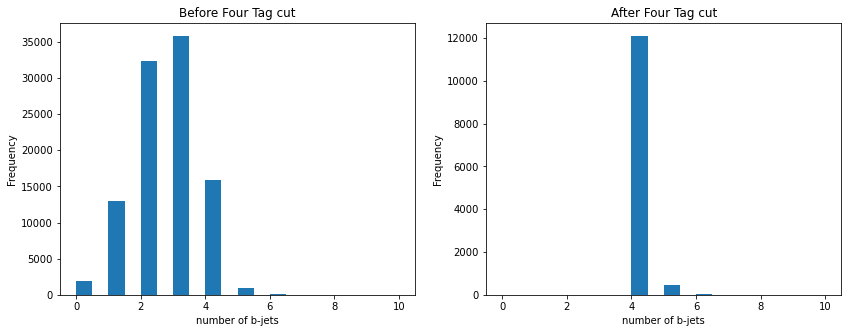

In [ ]:
data1 = np.array(nbj[0])
data2 = np.array(nbj[1])

print('Before Four Tag cut')
print("total events:", len(data1))
print("> 4 b-jets:", (data1 > 4).sum())
print('After Four Tag cut')
print("total events:", len(data2))
print("> 4 b-jets:", (data2 > 4).sum())

# title = "pp->4b"

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(data1, bins = 20, range=(0, 10))
ax[0].set_xlabel('number of b-jets')
ax[0].set_ylabel("Frequency")
ax[0].set_title('Before Four Tag cut')

ax[1].hist(data2, bins = 20, range=(0, 10))
ax[1].set_xlabel('number of b-jets')
ax[1].set_ylabel("Frequency")
ax[1].set_title('After Four Tag cut')

# plt.savefig("number_of_b-jets.png", facecolor="White")
plt.show()

## Higgs delta R

In [16]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
dR_s, m4j_s = get_diHiggs_deltaR_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:21<00:00, 571.82it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266


In [17]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
dR_4b, m4j_4b = get_diHiggs_deltaR_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:16<00:00, 568.59it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804


In [18]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'deltaR_minDHH'
dR_tt, m4j_tt = get_diHiggs_deltaR_m4j_HDF5(file_path, 
                                            tot_event=tot_event, 
                                            pairing_method=pairing_method, 
                                            xection = cross_section, 
                                            title='pp->tt->4j2b', 
                                            nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 585.91it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254


In [32]:
def plot_dR_m4j(dR, m4j, title = '', save_path=None):
    
    # dR[0] for leading Higgs, dR[1] for sub-leading Higgs

    # m4j = m4j_DHH_s
    dR1 = dR[0]
    dR2 = dR[1]

    fig, ax = plt.subplots(1, 2, figsize =(18, 7))

    R1_cut1_x = np.linspace(100, 1250, 100)
    R1_cut1_y = 653/R1_cut1_x + 0.475
    R1_cut1_2_x = np.linspace(1250, 1800, 100)
    R1_cut1_2_y = np.ones_like(R1_cut1_2_x)

    R1_cut2_x = np.linspace(100, 1250, 100)
    R1_cut2_y = 360/R1_cut2_x - 0.5
    R1_cut2_2_x = np.linspace(1250, 1800, 100)
    R1_cut2_2_y = np.zeros_like(R1_cut2_2_x)

    R2_cut1_x = np.linspace(100, 1250, 100)
    R2_cut1_y = 875/R2_cut1_x + 0.35
    R2_cut1_2_x = np.linspace(1250, 1800, 100)
    R2_cut1_2_y = np.ones_like(R1_cut1_2_x)

    R2_cut2_x = np.linspace(100, 1250, 100)
    R2_cut2_y = 235/R2_cut2_x
    R2_cut2_2_x = np.linspace(1250, 1800, 100)
    R2_cut2_2_y = np.zeros_like(R1_cut2_2_x)

    # Creating plot

    hs = ax[0].hist2d(m4j, dR1, bins = [50, 50], range = [[100, 1800], [0, 4.5]],  cmin=1)
    ax[0].set_xlabel('$M_{4j}$ (GeV)') 
    ax[0].set_ylabel('Leading $\Delta R$ ') 
    ax[0].set_title(title)
    ax[0].plot(R1_cut1_x, R1_cut1_y, color='r')
    ax[0].plot(R1_cut2_x, R1_cut2_y, color='r')
    ax[0].plot(R1_cut1_2_x, R1_cut1_2_y, color='r')
    ax[0].plot(R1_cut2_2_x, R1_cut2_2_y, color='r')
    fig.colorbar(hs[3], ax=ax[0])

    hs = ax[1].hist2d(m4j, dR2, bins = [50, 50], range = [[100, 1800], [0, 4.5]],  cmin=1)
    ax[1].set_xlabel('$M_{4j}$ (GeV)') 
    ax[1].set_ylabel('Sub-leading $\Delta R$') 
    ax[1].set_title(title)
    ax[1].plot(R2_cut1_x, R2_cut1_y, color='r')
    ax[1].plot(R2_cut2_x, R2_cut2_y, color='r')
    ax[1].plot(R2_cut1_2_x, R2_cut1_2_y, color='r')
    ax[1].plot(R2_cut2_2_x, R2_cut2_2_y, color='r')
    fig.colorbar(hs[3], ax=ax[1])

    if save_path: 
        plt.savefig(save_path, dpi=300, facecolor='White')

    plt.show()

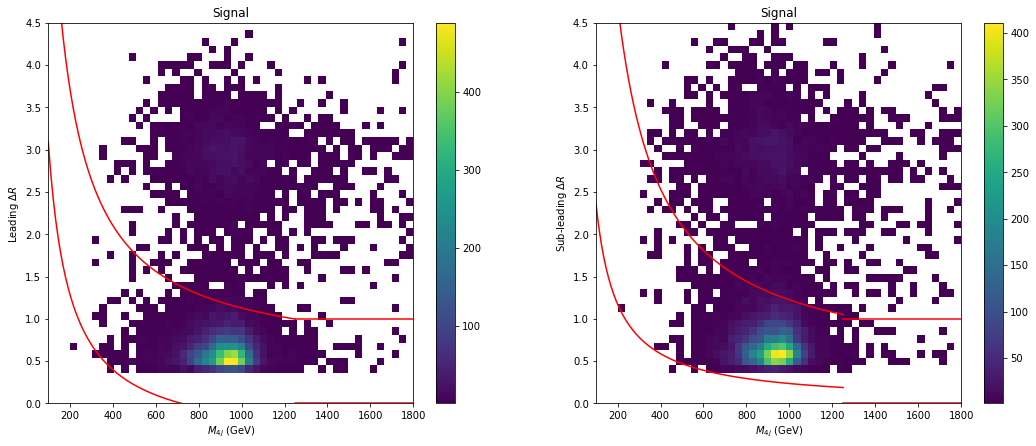

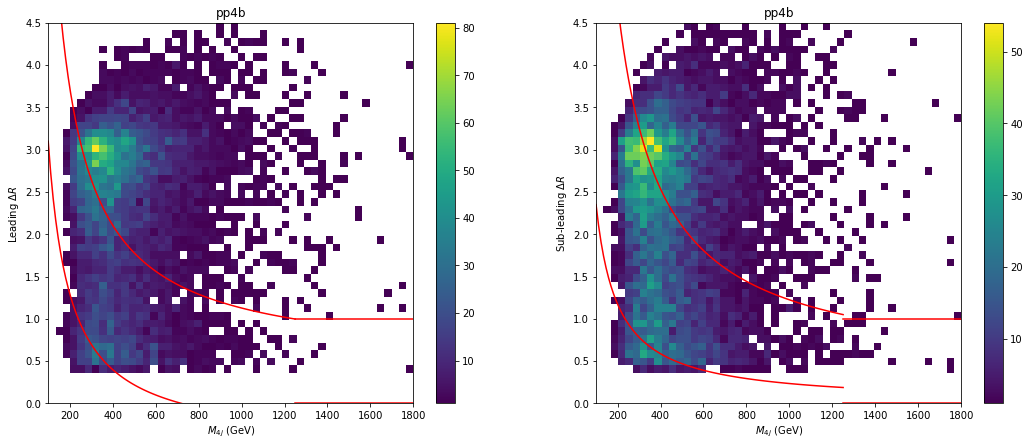

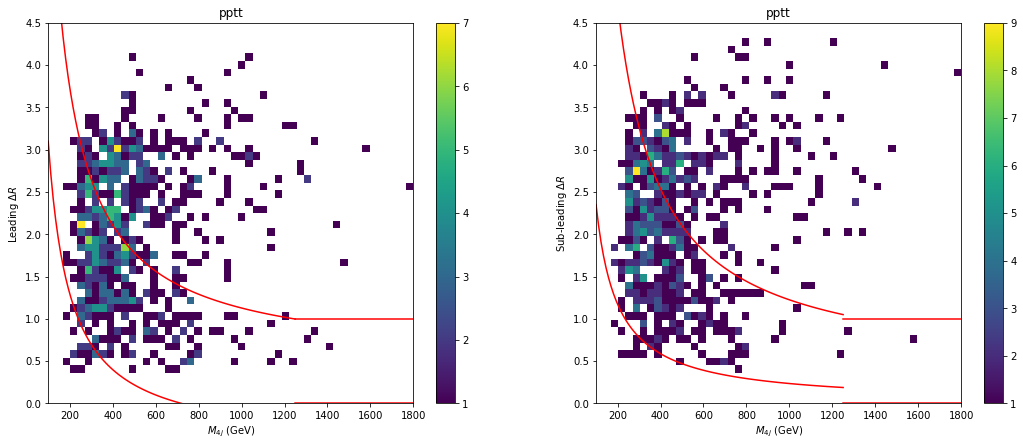

In [34]:
folder = '/home/r10222035/CPVDM/3-4-Higgs-Collider-Study/Analysis/figures/'
plot_dR_m4j(dR = dR_s, m4j=m4j_s, title = 'Signal', save_path=os.path.join(folder, 'Higgs_deltaR_m4j_s.png'))
plot_dR_m4j(dR = dR_4b, m4j=m4j_4b, title = 'pp4b', save_path=os.path.join(folder, 'Higgs_deltaR_m4j_4b.png'))
plot_dR_m4j(dR = dR_tt, m4j=m4j_tt, title = 'pptt', save_path=os.path.join(folder, 'Higgs_deltaR_m4j_tt.png'))

## Higgs candidate PT

In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
pt_DHH_s, m4j_DHH_s = get_diHiggs_PT_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:21<00:00, 583.04it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646


In [ ]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
pt_DHH_4b, m4j_DHH_4b = get_diHiggs_PT_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:16<00:00, 589.81it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694


In [ ]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'SPANet'
pt_SPANet_s, m4j_SPANet_s = get_diHiggs_PT_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:24<00:00, 516.25it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 12573 0.080995266
Higgs PT: 9756 0.06284815199999999


In [ ]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'SPANet'
pt_SPANet_4b, m4j_SPANet_4b = get_diHiggs_PT_m4j_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:18<00:00, 516.40it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 9642 6060.855622924804
Higgs PT: 6474 4069.4855115966793


### Plot

In [ ]:
def plot_PT_m4j(pt, m4j, title = ''):
    
    # pt[0] for leading Higgs, pt[1] for sub-leading Higgs

    # m4j = m4j_DHH_s
    pt1 = pt[0]
    pt2 = pt[1]

    fig, ax = plt.subplots(1, 2, figsize =(18, 7))

    # delta = 1
    x = np.linspace(0,2000,10)
    y1 = 0.5 * x - 103
    y2 = 0.33 * x - 73

    # Creating plot


    hs = ax[0].hist2d(m4j, pt1, bins = [50, 50], range = [[100, 1600], [0, 1000]],  cmin=1)
    ax[0].set_xlabel('M4j (GeV)') 
    ax[0].set_ylabel('PT1 (GeV)') 
    ax[0].set_title(title)
    ax[0].plot(x, y1, color='r')
    fig.colorbar(hs[3], ax=ax[0])

    hs = ax[1].hist2d(m4j, pt2, bins = [50, 50], range = [[100, 1600], [0, 1000]],  cmin=1)
    ax[1].set_xlabel('M4j (GeV)') 
    ax[1].set_ylabel('PT2 (GeV)') 
    ax[1].set_title(title)
    ax[1].plot(x, y2, color='r')
    fig.colorbar(hs[3], ax=ax[1])

    plt.show()

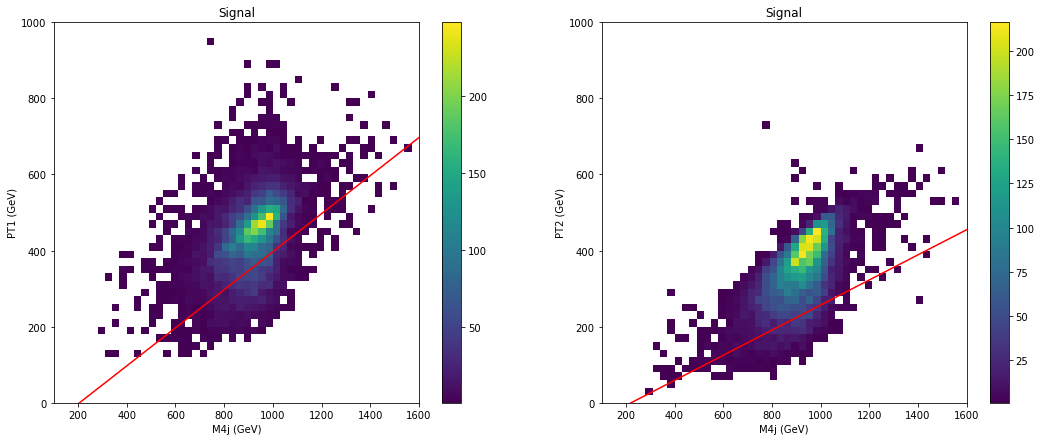

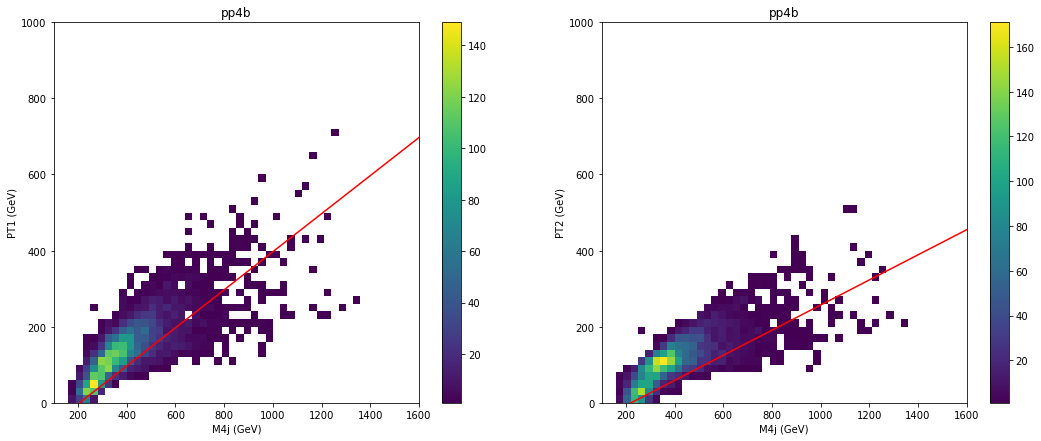

In [ ]:
plot_PT_m4j(pt = pt_DHH_s, m4j=m4j_DHH_s, title='Signal DHH')
plot_PT_m4j(pt = pt_DHH_4b, m4j=m4j_DHH_4b, title='pp4b DHH')

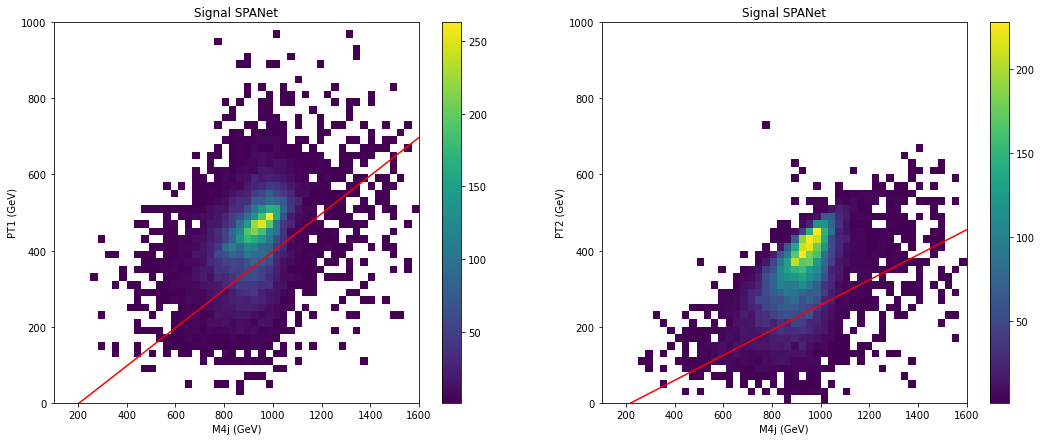

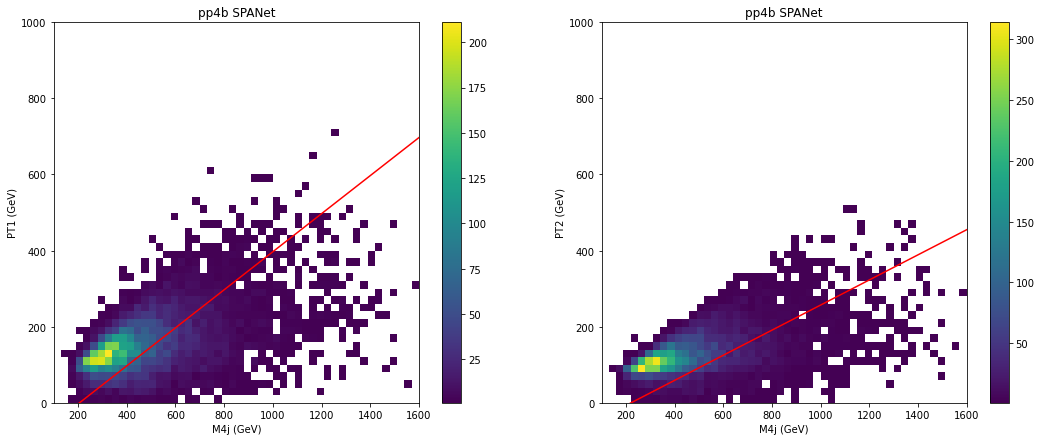

In [ ]:
plot_PT_m4j(pt = pt_SPANet_s, m4j=m4j_SPANet_s, title='Signal SPANet')
plot_PT_m4j(pt = pt_SPANet_4b, m4j=m4j_SPANet_4b, title='pp4b SPANet')

## Higgs candidate Delta Eta

In [77]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
dEta_DHH_s = get_diHiggs_dEta_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:21<00:00, 583.18it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646
Higgs Eta: 8260 0.05321092


In [90]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
dEta_DHH_4b = get_diHiggs_dEta_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:16<00:00, 594.12it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694
Higgs Eta: 3044 1913.4250690917968


In [106]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'SPANet'
dEta_SPANet_s = get_diHiggs_dEta_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:24<00:00, 506.91it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 12573 0.080995266
Higgs PT: 9756 0.06284815199999999
Higgs Eta: 8977 0.057829834


In [107]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'SPANet'
dEta_SPANet_4b = get_diHiggs_dEta_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:19<00:00, 502.21it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 9642 6060.855622924804
Higgs PT: 6474 4069.4855115966793
Higgs Eta: 4778 3003.3984822998045


In [104]:
def plot_dEta(dEta, title=''):
    fig, ax = plt.subplots(1, 1, figsize =(8, 7))

    ax.hist(dEta, bins=50, range=[0,3.5],  histtype='step')
    ax.set_xlabel('Delta Eta')
    ax.set_ylabel('Numbers')
    ax.set_title(title)

    plt.show()

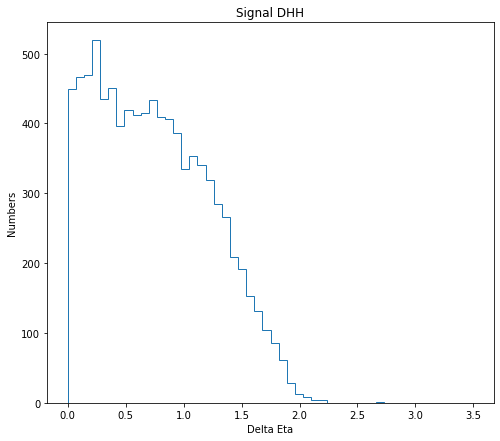

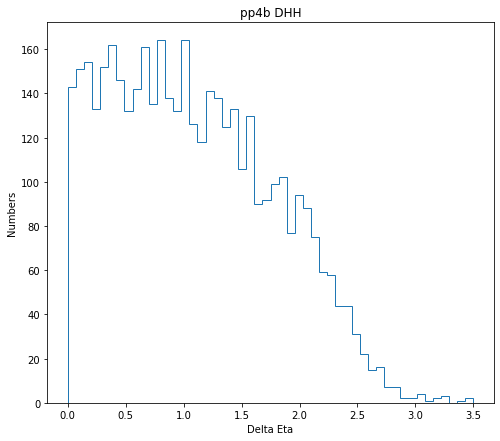

In [105]:
plot_dEta(dEta_DHH_s, title='Signal DHH')
plot_dEta(dEta_DHH_4b, title='pp4b DHH')

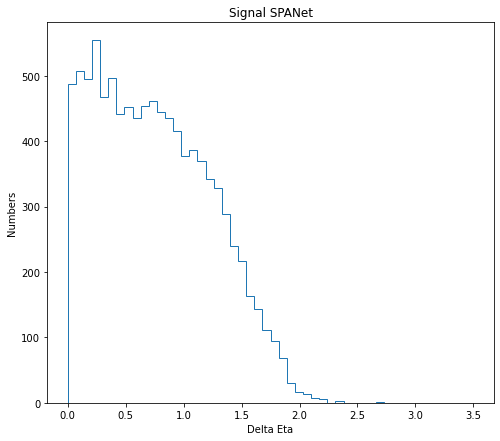

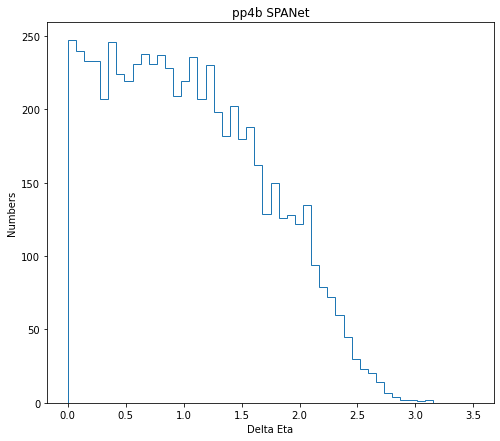

In [108]:
plot_dEta(dEta_SPANet_s, title='Signal SPANet')
plot_dEta(dEta_SPANet_4b, title='pp4b SPANet')

## Higgs candidate mass 

### Signal

In [35]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
mh_DHH_s = get_diHiggs_mass_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:23<00:00, 540.97it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646
Higgs Eta: 8260 0.05321092
Higgs signal region: 4453 0.028686226


In [36]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'SPANet'
mh_SPANet_s = get_diHiggs_mass_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:27<00:00, 464.01it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 12573 0.080995266
Higgs PT: 9756 0.06284815199999999
Higgs Eta: 8977 0.057829834
Higgs signal region: 4680 0.03014856


### Background 

In [37]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
mh_DHH_4b = get_diHiggs_mass_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:17<00:00, 564.97it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694
Higgs Eta: 3044 1913.4250690917968
Higgs signal region: 472 296.69403173828124


In [38]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'SPANet'
mh_SPANet_4b = get_diHiggs_mass_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:20<00:00, 467.04it/s]


pp->H->hh
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 9642 6060.855622924804
Higgs PT: 6474 4069.4855115966793
Higgs Eta: 4778 3003.3984822998045
Higgs signal region: 83 52.1728911743164


In [39]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'deltaR_minDHH'
mh_DHH_tt = get_diHiggs_mass_HDF5(file_path, 
                                    tot_event=tot_event, 
                                    pairing_method=pairing_method, 
                                    xection = cross_section, 
                                    title='pp->tt->4j2b', 
                                    nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 573.52it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Delta R: 418 110.20319720458984
Higgs PT: 370 97.54828460693359
Higgs Eta: 310 81.72964385986327
Higgs signal region: 67 17.664148834228516


In [40]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'SPANet'
mh_SPANet_tt = get_diHiggs_mass_HDF5(file_path, 
                                    tot_event=tot_event, 
                                    pairing_method=pairing_method, 
                                    xection = cross_section, 
                                    title='pp->tt->4j2b', 
                                    nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 482.30it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Delta R: 747 196.9420773010254
Higgs PT: 548 144.4769188232422
Higgs Eta: 444 117.05794152832031
Higgs signal region: 30 7.909320373535157


### Mass plane

In [53]:
def plot_mass_plane(mh, title='', save_path=None):
    # mh[0] for leading Higgs, mh[1] for sub-leading Higgs
    
    x_1 = mh[0]
    y_1 = mh[1]

    fig, ax = plt.subplots(1, 2, figsize =(18, 7))

    delta = 1
    xrange = np.arange(1, 250, delta)
    yrange = np.arange(1, 250, delta)
    X, Y = np.meshgrid(xrange,yrange)
    # F is one side of the equation, G is the other
    F = ((X-120)/(0.1*X))**2
    G = -((Y-110)/(0.1*Y))**2 + 1.6**2
    ax[0].contour((F - G), [0], colors='y')

    # Creating plot
    hs = ax[0].hist2d(x_1, y_1, bins = [50, 50], range = [[50, 250], [50, 250]], cmin=1)
    ax[0].set_xlabel('$M_{H_1}$ (GeV)') 
    ax[0].set_ylabel('$M_{H_2}$ (GeV)') 
    ax[0].set_title(title)
    fig.colorbar(hs[3], ax=ax[0])


    ax[1].hist(x_1, bins=50, range=[0,200], histtype='step', label='Leading Higgs')
    ax[1].hist(y_1, bins=50, range=[0,200], histtype='step', label='Sub-leanding Higgs')
    ax[1].set_xlabel('Higgs mass (GeV)')
    ax[1].set_ylabel('Numbers')
    ax[1].legend()
    ax[1].set_title(title)

    if save_path: 
        plt.savefig(save_path, dpi=300, facecolor='White')

    plt.show()

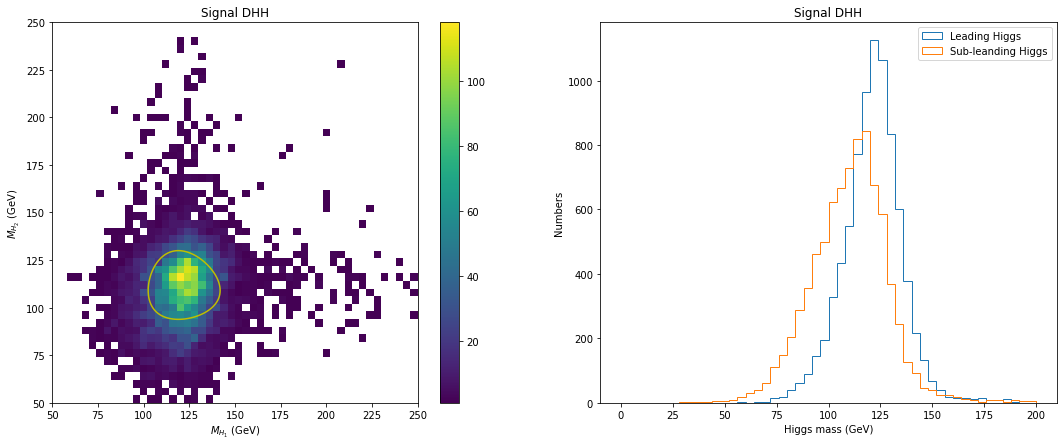

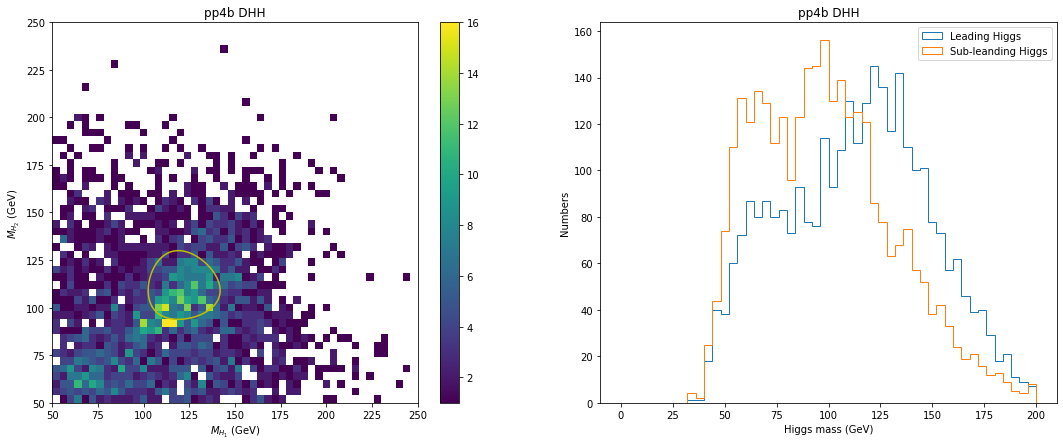

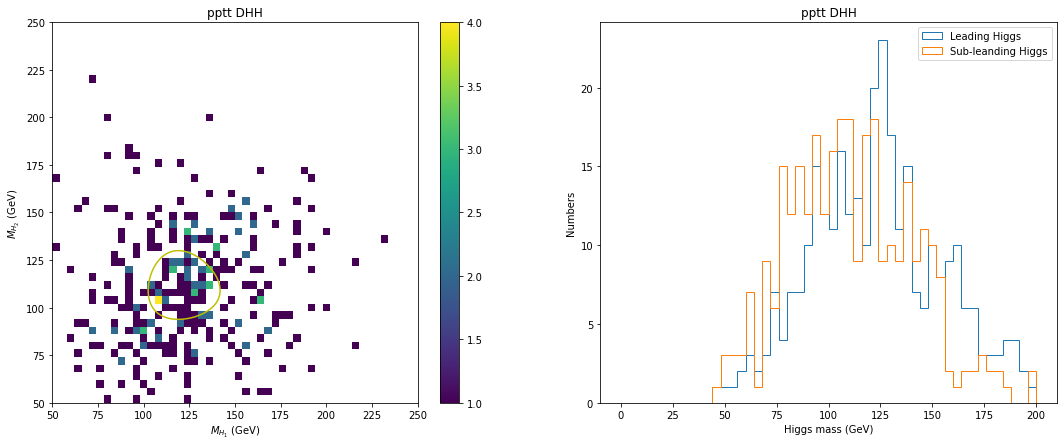

In [56]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
plot_mass_plane(mh_DHH_s, title = 'Signal DHH', save_path=os.path.join(figure_folder, 'Higgs_mass_DHH_s.png'))

# 13 TeV 100k pp->4b b-tagging part: MV2c10
plot_mass_plane(mh_DHH_4b, title = 'pp4b DHH', save_path=os.path.join(figure_folder, 'Higgs_mass_DHH_4b.png'))

# 13 TeV 1M pp->tt b-tagging part: MV2c10
plot_mass_plane(mh_DHH_tt, title = 'pptt DHH', save_path=os.path.join(figure_folder, 'Higgs_mass_DHH_tt.png'))

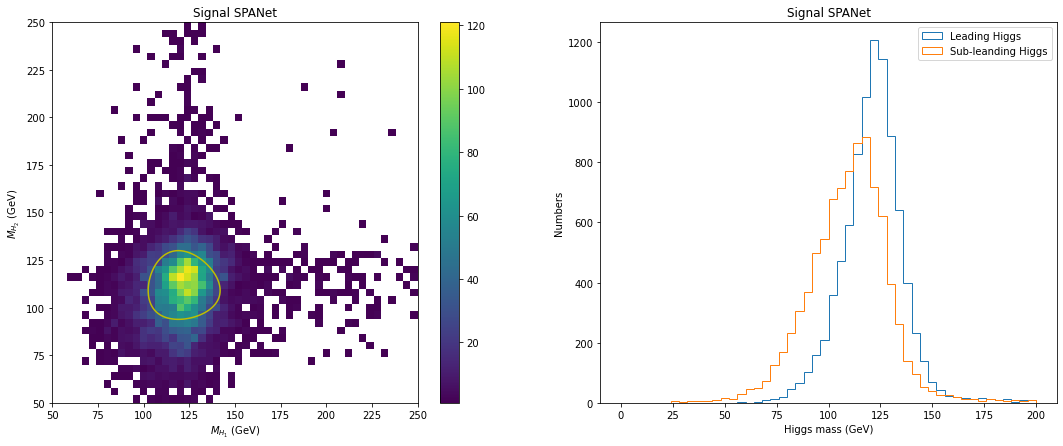

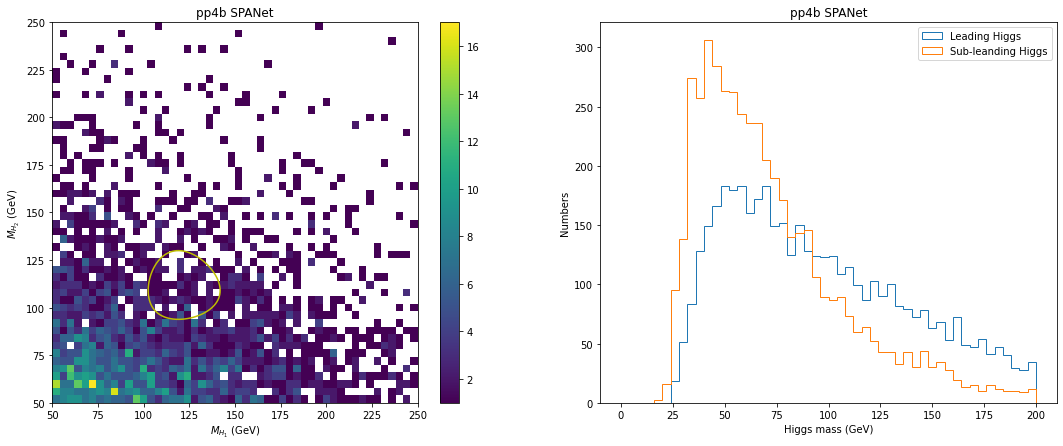

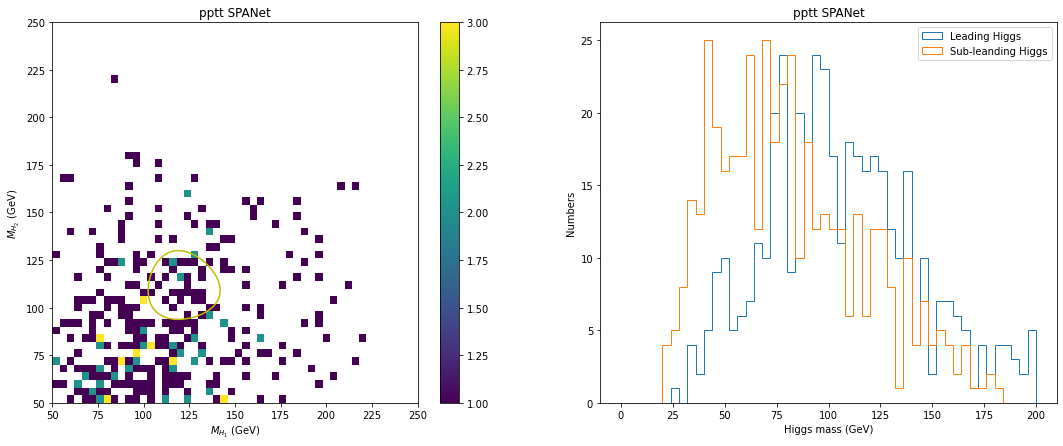

In [55]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
plot_mass_plane(mh_SPANet_s, title = 'Signal SPANet', save_path=os.path.join(figure_folder, 'Higgs_mass_SPANET_s.png'))

# 13 TeV 100k pp->4b b-tagging part: MV2c10
plot_mass_plane(mh_SPANet_4b, title = 'pp4b SPANet', save_path=os.path.join(figure_folder, 'Higgs_mass_SPANET_4b.png'))

# 13 TeV 1M pp->tt b-tagging part: MV2c10
plot_mass_plane(mh_SPANet_tt, title = 'pptt SPANet', save_path=os.path.join(figure_folder, 'Higgs_mass_SPANET_tt.png'))

## DiHiggs mass

In [50]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'deltaR_minDHH'
mHH_DHH_4b = get_mHH_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:20<00:00, 460.49it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Delta R: 5047 3172.488936828613
Higgs PT: 4271 2684.7038338012694
Higgs Eta: 3044 1913.4250690917968
Higgs signal region: 472 296.69403173828124
Top veto: 282 177.26211218261716


In [58]:
# 13 TeV 1M pp->4b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/pp4b/Events/run_13/...'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_background_predict.h5'
tot_event = 1000000
cross_section = 628589.0502929688
pairing_method = 'SPANet'
mHH_SPANet_4b = get_mHH_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->4b', 
                                  nevent_max=100000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9642/9642 [00:24<00:00, 398.33it/s]

pp->4b
In 9642 events
Cross section: 628589.0502929688 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 9642 6060.855622924804
Higgs PT: 6474 4069.4855115966793
Higgs Eta: 4778 3003.3984822998045
Higgs signal region: 83 52.1728911743164
Top veto: 72 45.25841162109375


In [38]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'deltaR_minDHH'
mHH_DHH_s = get_mHH_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:37<00:00, 333.75it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Delta R: 10868 0.070011656
Higgs PT: 8963 0.057739646
Higgs Eta: 8260 0.05321092
Higgs signal region: 4453 0.028686226
Top veto: 4255 0.027410709999999998


In [59]:
# 13 TeV 100k pp->H->hh b-tagging part: MV2c10 H = 1000 GeV
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/proc_ppHhh/Events/run_66_decayed_1/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/100k_diHiggs_4b_MV2c10_PT40_signal_predict.h5'
tot_event = 100000
cross_section = 0.6442
pairing_method = 'SPANet'
mHH_SPANet_s = get_mHH_HDF5(file_path, 
                                  tot_event=tot_event, 
                                  pairing_method=pairing_method, 
                                  xection = cross_section, 
                                  title='pp->H->hh', 
                                  nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12573/12573 [00:43<00:00, 290.63it/s]

pp->H->hh
In 12573 events
Cross section: 0.6442 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 12573 0.080995266
Higgs PT: 9756 0.06284815199999999
Higgs Eta: 8977 0.057829834
Higgs signal region: 4680 0.03014856
Top veto: 4462 0.028744204


In [67]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'deltaR_minDHH'
mHH_DHH_tt = get_mHH_HDF5(file_path, 
                                    tot_event=tot_event, 
                                    pairing_method=pairing_method, 
                                    xection = cross_section, 
                                    title='pp->tt->4j2b', 
                                    nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 475.80it/s]


pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Delta R: 418 110.20319720458984
Higgs PT: 370 97.54828460693359
Higgs Eta: 310 81.72964385986327
Higgs signal region: 67 17.664148834228516
Top veto: 21 5.536524261474609


In [ ]:
# 13 TeV 1M pp->tt->4j2b b-tagging part: MV2c10 
# file_path = '/home/r10222035/Software/MG5_aMC_v3_3_1/CPVDM/ppttbar/Events/run_03/tag_1_delphes_events.root'
file_path = '/home/r10222035/CPVDM/h5_data/1M_diHiggs_4b_MV2c10_PT40_pptt_predict.h5'
tot_event = 1000000
cross_section = 263644.0124511719
pairing_method = 'SPANet'
mHH_SPANet_tt = get_mHH_HDF5(file_path, 
                                    tot_event=tot_event, 
                                    pairing_method=pairing_method, 
                                    xection = cross_section, 
                                    title='pp->tt->4j2b', 
                                    nevent_max=100000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [00:01<00:00, 407.80it/s]

pp->tt->4j2b
In 747 events
Cross section: 263644.0124511719 fb
|eta| < 2.5, PT > 40 GeV for 4 b-jets: 747 196.9420773010254
Higgs PT: 548 144.4769188232422
Higgs Eta: 444 117.05794152832031
Higgs signal region: 30 7.909320373535157
Top veto: 10 2.6364401245117186


In [63]:
def plot_mHH(mHH, title=''):
    m = mHH[0]
    m_cor = mHH[1]
    fig, ax = plt.subplots(1, 1, figsize =(8, 7))

    ax.hist(m, bins=50,  histtype='step', label='uncorrected')
    ax.hist(m_cor, bins=50,   histtype='step', label='corrected')
    ax.set_xlabel('Di-Higgs mass (GeV)')
    ax.set_ylabel('Numbers')
    ax.set_title(title)
    ax.legend()

    plt.show()

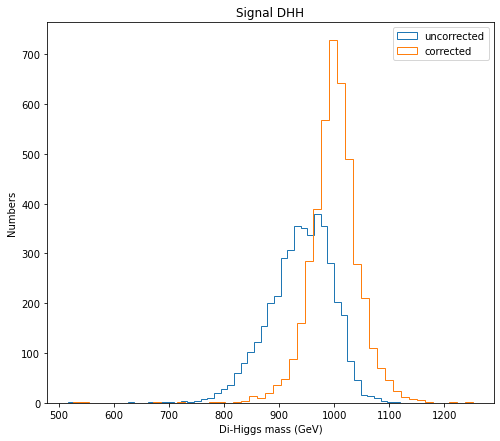

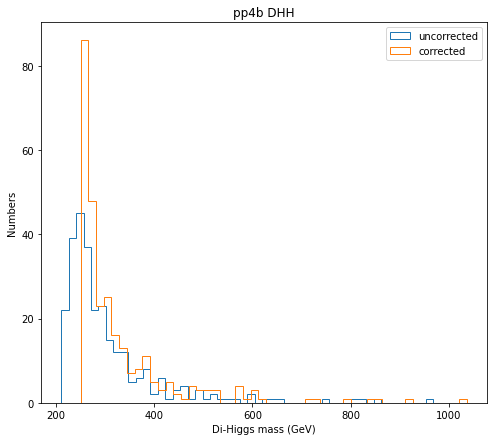

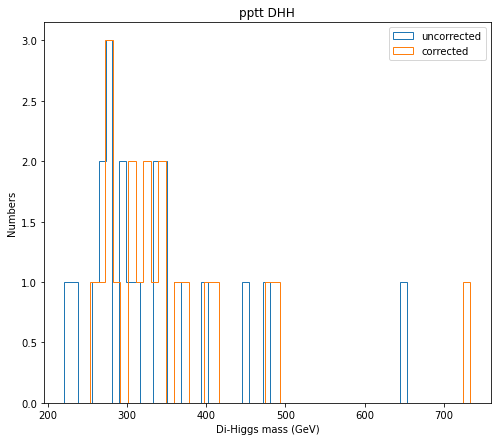

In [68]:
plot_mHH(mHH_DHH_s, title='Signal DHH')

plot_mHH(mHH_DHH_4b, title='pp4b DHH')

plot_mHH(mHH_DHH_tt, title='pptt DHH')

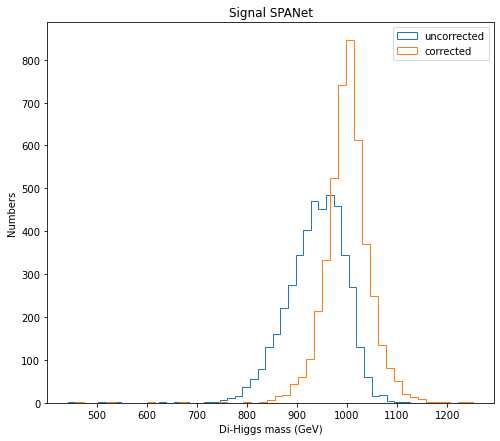

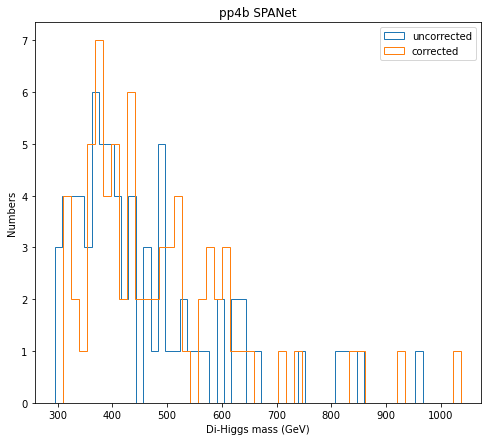

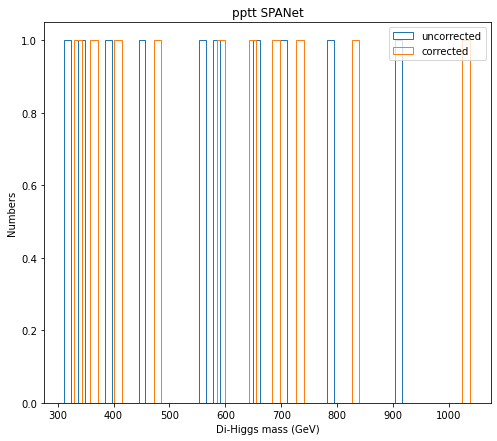

In [69]:
plot_mHH(mHH_SPANet_s, title='Signal SPANet')

plot_mHH(mHH_SPANet_4b, title='pp4b SPANet')

plot_mHH(mHH_SPANet_tt, title='pptt SPANet')